# Transformed Eulerian Mean diagnostic

In [1]:
%load_ext watermark

import dask.array
import dask_jobqueue
import distributed
import flox
import pandas as pd
import xarray as xr
from distributed import performance_report
from distributed.diagnostics.memory_sampler import MemorySampler

%watermark -iv

flox         : 0.5.9
json         : 2.0.9
pandas       : 1.4.3
sys          : 3.10.5 | packaged by conda-forge | (main, Jun 14 2022, 07:06:46) [GCC 10.3.0]
xarray       : 2022.6.0rc0
dask         : 2022.9.2
distributed  : 2022.9.2
dask_jobqueue: 0.8.1



In [2]:
from contextlib import contextmanager


@contextmanager
def get_cluster(*, n_workers, env=None, config=None):
    
    import os

    import dask_jobqueue
    import distributed
    
    print(config)
    
    with dask.config.set(config):
        cluster = dask_jobqueue.PBSCluster(
                cores=2,  # The number of cores you want
                memory="23GB",  # Amount of memory
                processes=1,  # How many processes
                queue="casper",  # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
                local_directory="$TMPDIR",  # Use your local directory
                resource_spec="select=1:ncpus=2:mem=23GB",  # Specify resources
                account="ncgd0011",  # Input your project ID here
                walltime="02:00:00",  # Amount of wall time
                interface="ib0",  # Interface to use
                job_script_prologue=[f"export {k}={v}" for k, v in env.items()],

            )
        client = distributed.Client(cluster)
        # client.run_on_scheduler(lambda dask_scheduler: setattr(dask_scheduler, "WORKER_SATURATION", config["distributed.scheduler.worker-saturation"]))
        cluster.scale(n_workers)
        client.wait_for_workers(n_workers)
        
    print(client.dashboard_link)
    
    yield cluster, client
    
    print("closing")
    client.close()
    cluster.close()

from functools import partial


def check_config(dask_scheduler, config):
    
    print(dask_scheduler.WORKER_SATURATION)
    assert str(dask_scheduler.WORKER_SATURATION) == config["distributed.scheduler.worker-saturation"], (dask_scheduler.WORKER_SATURATION, config["distributed.scheduler.worker-saturation"])

In [3]:
repeats = 1

ms = MemorySampler()
for val in ["1.0", "1.2", "inf"]:
    config = {"distributed.scheduler.worker-saturation": val}
    env={"DASK_DISTRIBUTED__SCHEDULER__WORKER_SATURATION": val}

    with get_cluster(n_workers=8, env=env, config=config) as (cluster, client):
        client.run_on_scheduler(partial(check_config, config=config))

        dims = ("time", "level", "lat", "lon")
        # 1 is number of years, adjust to make bigger, 
        # full dataset is 60-ish years.
        shape = (1 * 365 * 24, 37, 72, 1440)
        chunks = (24, 15, -1, -1)

        ds = xr.Dataset(
            {
                "U": (dims, dask.array.random.random(shape, chunks=chunks)),
                "V": (dims, dask.array.random.random(shape, chunks=chunks)),
                "W": (dims, dask.array.random.random(shape, chunks=chunks)),
                "T": (dims, dask.array.random.random(shape, chunks=chunks)),
            },
            coords={"time": pd.date_range("2001-01-01", periods=shape[0], freq="H")},
        )
        zonal_means = ds.mean("lon")
        anomaly = ds - zonal_means

        anomaly['uv'] = anomaly.U*anomaly.V
        anomaly['vt'] = anomaly.V*anomaly.T
        anomaly['uw'] = anomaly.U*anomaly.W

        temdiags = zonal_means.merge(anomaly[['uv','vt','uw']].mean("lon"))

        temdiags = temdiags.groupby('time.dayofyear').mean()
        temdiags = temdiags.rename({'dayofyear':'time'})

        with performance_report(f"tem-saturation-{val}.html"):
            for repeat in range(repeats):
                with ms.sample(f"{val}_{repeat}"):
                    temdiags.compute()
                client.restart()

{'distributed.scheduler.worker-saturation': '1.0'}


/glade/u/home/dcherian/miniconda3/envs/pump/lib/python3.10/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39292 instead
  warnings.warn(


https://jupyterhub.hpc.ucar.edu/stable/user/dcherian/proxy/39292/status
1.0
closing
{'distributed.scheduler.worker-saturation': '1.2'}


/glade/u/home/dcherian/miniconda3/envs/pump/lib/python3.10/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35998 instead
  warnings.warn(


https://jupyterhub.hpc.ucar.edu/stable/user/dcherian/proxy/35998/status
1.2
closing
{'distributed.scheduler.worker-saturation': 'inf'}


/glade/u/home/dcherian/miniconda3/envs/pump/lib/python3.10/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37805 instead
  warnings.warn(


https://jupyterhub.hpc.ucar.edu/stable/user/dcherian/proxy/37805/status
inf
closing


<AxesSubplot:xlabel='time', ylabel='Cluster memory (GiB)'>

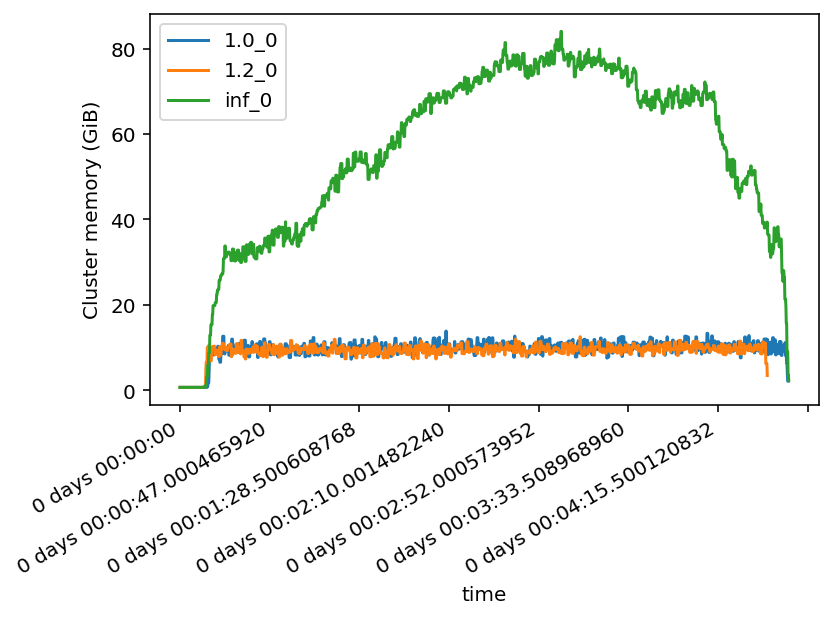

In [4]:
ms.plot(align=True)

In [5]:
ms.to_pandas().to_csv("tem.csv")